# VMR profiles Tutorial
This tutorial shows how to create and volume-mixing ratio (VMR) profiles for *free-chemistry* models.

Let's start by importing some necessary modules:

In [40]:
import pyratbay.constants as pc
import pyratbay.atmosphere as pa

import matplotlib.pyplot as plt
import numpy as np

## 1. Isobaric VMR models
This is the standard constant-with-altitude VMR model.  These models have a single parameter (``log_X``, where ``X`` is named after the species' name), which defines the $\log_{10}({\rm VMR})$ for the given species.


In [41]:
# Define a pressure profile where to evaluate the VMR models:
nlayers = 101
ptop = '1e-7 bar'
pbottom = '100 bar'
# See help(pa.pressure) for alternative ways to set the boundaries/units
pressure_cgs = pa.pressure(ptop, pbottom, nlayers)
# Same pressure array but in bar units:
pressure = pressure_cgs / pc.bar

# Create a simple atmosphere used as a base VMR
tmodel = pa.tmodels.Isothermal(pressure)
species = ["H2", "He", "H2O", "CO", "CO2", "CH4"]
abundances = [0.85, 0.15, 1e-4, 1e-4, 1e-6, 1e-4]
vmr = pa.uniform(abundances, nlayers)

# Define free VMR models
vmr_models = [
    pa.vmr_models.IsoVMR('H2O', pressure),
    pa.vmr_models.IsoVMR('CO', pressure),
]
# Define 'bulk' species, these will self-adjust such that sum(VMR)=1 at each layer:
bulk = ['H2', 'He']

Text(0.5, 0, 'VMR')

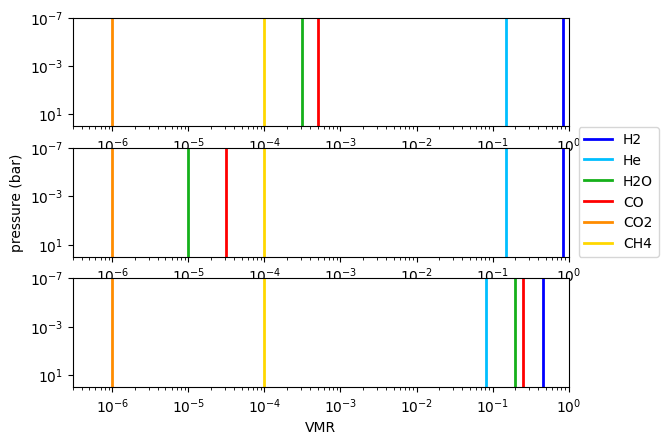

In [42]:
# The vmr_scale() function evaluates the VMR models over an input atmosphere
vmr_pars1 = [-3.5, -3.3]
vmr_pars2 = [-5.0, -4.5]
vmr_pars3 = [-0.7, -0.6]
vmr1 = pa.vmr_scale(vmr, species, vmr_models, vmr_pars1, bulk)
vmr2 = pa.vmr_scale(vmr, species, vmr_models, vmr_pars2, bulk)
vmr3 = pa.vmr_scale(vmr, species, vmr_models, vmr_pars3, bulk)

vmrs = [vmr1, vmr2, vmr3]
cols = {
    'H2': 'blue',
    'He': 'deepskyblue',
    'H2O': 'xkcd:green',
    'CO': 'red',
    'CO2': 'darkorange',
    'CH4': 'gold',
    'HCN': 'black',
    'NH3': 'violet',
}
fig = plt.figure(0)
plt.clf()
for i in range(3):
    ax = plt.subplot(3,1,1+i)
    ax.set_xscale('log')
    ax.set_yscale('log')
    for j,spec in enumerate(species):
        col = cols[spec]
        ax.plot(vmrs[i][:,j], pressure, label=spec, lw=2, c=col)
    if i == 1:
        ax.legend(loc=(1.02, 0.0))
        ax.set_ylabel('pressure (bar)')
    ax.set_ylim(1e2, 1e-7)
    ax.set_xlim(3e-7, 1)
ax.set_xlabel('VMR')

## 2 Non-isobaric VMR models

This model implements a slanted (or slanted + isobaric) VMR profile.  These models have five parameters (where ``X`` is named after the species' name):


| Parameter name | Description |
| --- | --- | 
| ``slope_X`` | Slope of VMR profile, defined as: ${\rm d}(\log {\rm VMR}) / {\rm d}(\log p)$ | 
| ``log_VMR0_X`` | Reference VMR value at pressure defined by ``log_p0_X`` |
| ``log_p0_X`` | Reference pressure level where VMR is defined by ``log_p0_X`` | 
| ``max_log_X`` | Minimum VMR value (at whcih the slanted VMR profile will be capped) | 
| ``min_log_X`` | Maximum VMR value (at which the slanted VMR profile will be capped) | 

In this way, this model can simulate a wide variety of profiles seen in equilibrium or disequilibrium chemistry calculations.
Note that ``VMR0`` and ``p0`` are a redundant pair of parameters, typically you want to keep one fixed and fit for the other.

Also, note that for retrieval approaches, one does not need to have all five parameters free. As little as two are sufficient for a slanted profile (e.g., ``log_VMR0_X`` and ``slope_X``).   To simulate vertical quenching it would be sufficient, e.g., to let  ``min_log_X`` free to create a quencing VMR value.

In [43]:
# Setup a base VMR atmosphere
species = 'H2 He H2O CH4  CO CO2 HCN NH3'.split()
abundances = [
    0.850,  0.150,  1.4e-2, 1.0e-3,
    5.5e-3, 2.2e-6, 1.0e-7, 1.0e-6,
]
vmr = pa.uniform(abundances, nlayers)
bulk = ['H2', 'He']

# Setup constant VMR models for H2O, CO, and CO2, non-isobaric for CH4
vmr_models = [
    pa.vmr_models.IsoVMR('H2O', pressure_cgs),
    pa.vmr_models.IsoVMR('CO', pressure_cgs),
    pa.vmr_models.SlantVMR('CH4', pressure_cgs),
]

# A print() call shows some basic info about these models
for model in vmr_models:
    print(model)

VMR model name: log_H2O
Number of parameters: 1
Parameters: ['log_H2O']

VMR model name: log_CO
Number of parameters: 1
Parameters: ['log_CO']

VMR model name: slant_CH4
Number of parameters: 5
Parameters: ['slope_CH4', 'log_VMR0_CH4', 'log_p0_CH4', 'min_log_CH4', 'max_log_CH4']



Text(0.5, 0, 'VMR')

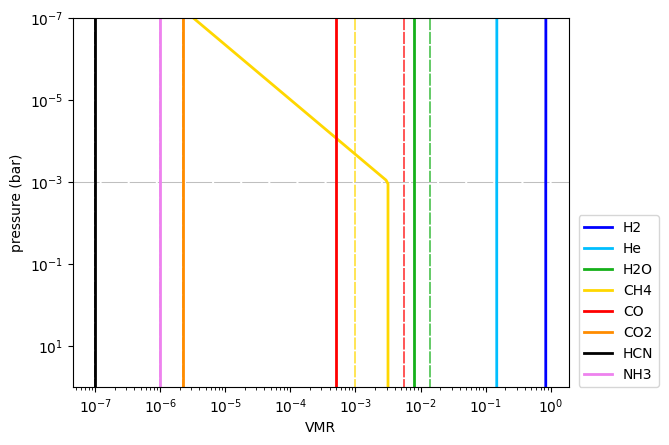

In [44]:
# Define list of VMR parameters for each VMR model, note SlantVMR() requires 5 parameters):
vmr_pars = [
    -2.1, 
    -3.3,
    # m    VMR0   p0    min      max
    [0.75, -2.5, -3.0, -np.inf, -2.5],
]
vmr4 = pa.vmr_scale(vmr, species, vmr_models, vmr_pars, bulk)

fig = plt.figure(1)
plt.clf()
ax = plt.subplot(111)
ax.set_xscale('log')
ax.set_yscale('log')
plt.axhline(10**-3, color='0.75', dashes=(25,2), lw=0.75)
for j,spec in enumerate(species):
    col = cols[spec]
    ax.plot(vmr4[:,j], pressure, label=spec, lw=2, c=col)
    ax.plot(vmr[:,j], pressure, lw=1.25, c=col, alpha=0.75, zorder=-1, dashes=(7,1))
ax.legend(loc=(1.02, 0.0))
ax.set_ylabel('pressure (bar)')
ax.set_ylim(1e2, 1e-7)
ax.set_xlabel('VMR')